# Сверточные сети

Вспомним, что зависимость точности от размера обучающей выборки выглядит следующим образом:
<img src="img/lecBayes/Hughes2.png" height="30%">
Hughes G. On the mean accuracy of statistical pattern recognizers //IEEE transactions on information theory. – 1968

**Почему при конечной выборке сначала точность классификаторов увеличивается, а затем после некоторого предела падает?**

Две противоположные тенденции:

* с увеличением размерности разделимость классов также увеличивается (может увеличиться);
* чем больше размерность, тем больше параметров классификатора нужно оценить.



Светочные сети хорошо работают там, где "буксуют" полносвязные сети. Это, в первую очередь, обработка аудиоданных и изображений. Эти данные отличаются:
 * ~~избыточностью~~ ~~многовловностью~~ большим объемом схожей информации; например, изображение размером $100\times 100 = 10~000$ пикселей. Если подавать его на вход нейросети так, как оно есть, получаем 10 тыс. входов, при этом соседние пиксели будут очень похожи по характеристикам.
 * описываемые объекты/явления характеризуются вариативностью в масштабе, деформациях и прочих искажениях и преобразованиях. 

## Фильтрация изображений

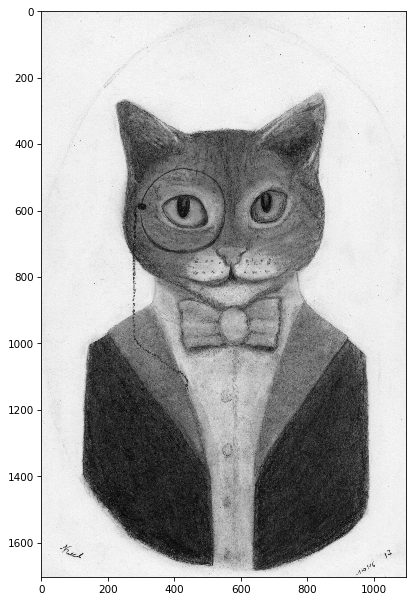

In [1]:
%matplotlib inline

from PIL import Image
from scipy import ndimage
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

im = Image.open("img/cnn/test.png")
img_array = np.asarray(im)[:, :, 0]/ 255.0

plt.figure(figsize=(20,10), dpi=75)
imshow(img_array,  cmap='gray')

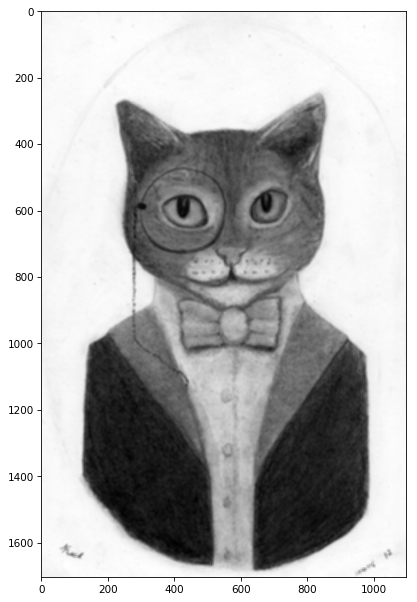

In [2]:
ker = (1/(9*9.0))*np.ones((9, 9))

# Convolve
smooth = ndimage.convolve(img_array, ker)

plt.figure(figsize=(20,10), dpi=75)
imshow(smooth, cmap='gray')


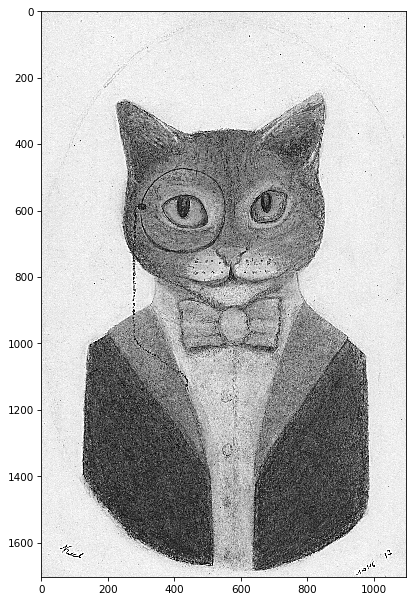

In [3]:
diff = img_array - smooth
res = img_array + 2*diff

res = np.maximum(res, np.zeros(res.shape))
res = np.minimum(res, np.ones(res.shape))
# print(res)

plt.figure(figsize=(20,10), dpi=75)
imshow(res, cmap='gray')

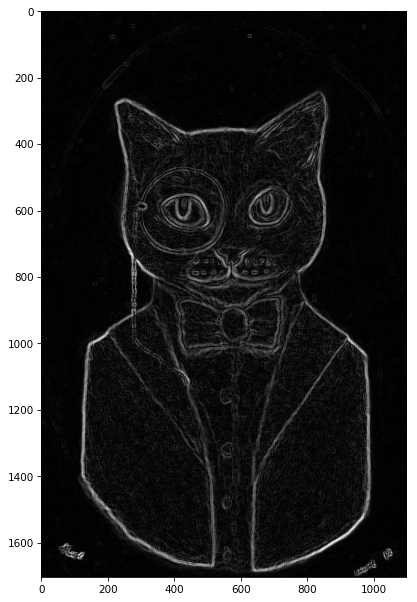

In [4]:
k1 = np.array([[-1, -2, -1],
              [0, 0, 0],
              [1, 2, 1]])

k2 = np.array([[-1, 0, 1],
              [-2, 0, 2],
              [-1, 0, 1]])

g1 = ndimage.convolve(smooth, k1)
g2 = ndimage.convolve(smooth, k2)

g = np.abs(g1) + np.abs(g2)

plt.figure(figsize=(20,10), dpi=75)
imshow(g, cmap='gray')


## Принципы работы сверточных сетей

* Сверточная сеть -- мноroслойный персептрон, специфического вида созданный для распознавания одно-/дву-/трех/...-мерных поверхностей с высокой степенью инвариантности к преобразованиям и деформациям. 

* Слои имеют четко выраженные назначения.

* Обучение осуществляется с учителем.

[<img src="img/cnn/CNNtopo.png" height="30%">](https://commons.wikimedia.org/wiki/File:Typical_cnn.png#/media/File:Typical_cnn.png)

LeCun Y., Y. Bengio. "Convolutional networks for images, speech and time series", 1995.


### Архитектура сети

* Извлечение признаков. Каждый нейрон получает входной сиrнал от локальноrо рецептивого поля в предыдущем слое, извлекая таким образом еro локальные признаки. Как только признак извлечен, ero точное местоположение не имеет значения, поскольку приблизительно установлено ero расположение относительно других признаков.
[<img src="img/cnn/CNNtopo.png" height="30%">](https://commons.wikimedia.org/wiki/File:Typical_cnn.png#/media/File:Typical_cnn.png)

* Отображение признаков. Каждый вычислительный слой сети состоит из множества карт признаков, на котором все нейроны должны совместно использовать одно и то же множество синаптических весов. Это обеспечивает:
 1. Инвариантность к смещению, реализованную посредством свертки с ядром небольшого размера.
 2. Сокращение числа свободных параметров.
[<img src="img/cnn/CNNtopo.png" height="30%">](https://commons.wikimedia.org/wiki/File:Typical_cnn.png#/media/File:Typical_cnn.png)

* Подвыборка. За каждым слоем свертки следует вычислительный слой, осуществляющий локальное усреднение и подвыборку. Посредством этоro достиrается уменьшение разрешения для карт признакав. Эта операция приводит к уменьшению чувствительности выходноrо сиrнала оператора отображения признакав, к смещению и прочим формам деформации.
[<img src="img/cnn/CNNtopo.png" height="30%">](https://commons.wikimedia.org/wiki/File:Typical_cnn.png#/media/File:Typical_cnn.png)

(Пример распознавания рукописных символов)

[<img src="img/cnn/CNNtopo.png" height="30%">](https://commons.wikimedia.org/wiki/File:Typical_cnn.png#/media/File:Typical_cnn.png)

Схема работы сверточной сети такова:

0. На вход подаются изображения 28x28 пикселей - изображения символов.
1. Первый скрытый слой: выполняет свертку. Состоит из 4-х карт признаков (4 разных фильтра по 5x5 нейронов). Каждая карта - матрица из 24x24 нейронов.
2. Второй скрытый слой: подвыборка и локальное усреднние. Каждый слой - 4 матрицы по 12x12 нейронов.
3. Третий скрытый слой: повторная свертка. Состоит из 12 карт признаков 8x8 нейронов.
4. Четвертый скрытый слой: вторая подвыборка и усреднение.
5. Полносвязная нейронная сеть.

Многослойный перцептрон подобной архитектуры содержал бы ~100000 различных весов. Данная сверточная сеть содержит 2600 свободных параметров.

Часто используются следующие следующие схемы:

1. Последовательность сверток:
 CONN -> ReLU -> CONN -> ReLU -> ... -> CONN -> ReLU -> MLP
 
2. Свертки и подвыборки:
 CONN -> ReLU -> Pool->  CONN -> ReLU -> Pool -> ... -> MLP

#### Некоторые подробности

1. На результат свертки влияет шаг (stride), на который сдвигается рецептивное поле нейронов (~ скользящее окно). Может быть 1, 2, ... . Часто $stride=\frac{F-1}2$, $F$ -- размер ядра свертки.
2. Заполнение краев:
 - нет заполнения;
 - нули;
 - копии;
 - зеркально.
3. "Толщина" выхода сверточнго слоя - число фильтров. Например:
  3x32x32 -> N сверток 3x3 -> Nx30x30
5. Число параметров сверточного слоя. Например, 10 фильтров 5x5 на RGB изображении: 760 весов.

Итог по сверточному слою (для изображений):
1. Принимает на вход "объемы" W1xH1xD1.
2. Имеет 4 гиперпараметра:
 * число фильтров;
 * размер ядра F;
 * шаг Stride;
 * параметр заполнения.
3. Возвращает "объемы" W2xH2xD2.
4. Веса нейронов одинаковы внутри каждого фильра (разделяемые параметры).

Слой подвыборки (обычно это MaxPool, но возможны и "настоящие" нейроны):
1. Имеет 3 гиперпараметра:
 * размер (2x2);
 * шаг (2);
 * операция
2. Принимает на вход "объемы" W1xH1xD1.
3. Выдает "объемы" W2xH2xD2 (D2=D1).

Преимущества сверточных сетей перед классическим многослойным перцептроном (в задаче анализа изображений):
 * значительное сокращение числа параметров => повышение способности к обобщению;
 * слабая взаимная зависимость фильтров => параллельность обработки;
 * автоматическое выделение признаков;
 * устойчивость к искажениям входных данных.